In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl

sys.path.append('models')
from sim_cosmology import p, load_dataloader_and_pretrained_model
# adaptive-wavelets modules
sys.path.append('../../src')
sys.path.append('../../src/adaptive_wavelets')
from losses import get_loss_f
from train import Trainer, Validator
from transform2d import DWT
from utils import get_2dfilts
from viz import viz_im_r, cshow, viz_filters, viz_list

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p, img_size=256)

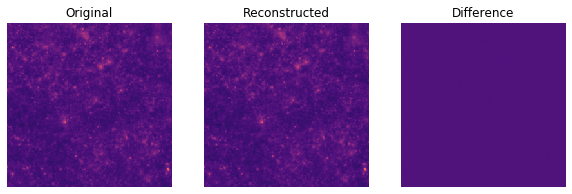

Recon=0.00000


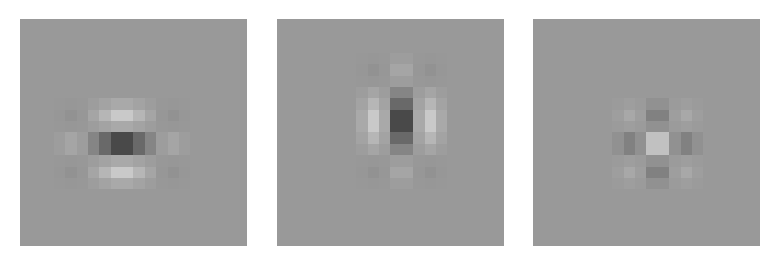

In [33]:
# get image
torch.manual_seed(p.seed)
im = iter(test_loader).next()[0][0:64].to(device)

# wavelet transform 
wt = DWT(wave='db2', mode='symmetric', J=3, init_factor=1, noise_factor=0).to(device)
viz_im_r(im[0], wt.inverse(wt(im))[0])
print("Recon={:.5f}".format(torch.norm(wt_orig.inverse(wt_orig(im)) - im)**2/im.size(0)))

filt = get_2dfilts(wt_orig)
viz_list(filt, figsize=(4,4))